## code for creating a spam filter

First import packages and read in the data.

In [1]:
import random
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import punkt
# from nltk.stem import wordnet


In [2]:
# nltk.download('omw-1.4')

In [3]:
spam = pd.read_csv(r"C:\Users\Cory\Dropbox\PC\Documents\ENTITY\final_project\spamhamdata.csv", sep='\t', header=None, names=['Label', 'SMS'])

In [4]:
spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Convert dataframe into a list of tuples. Each tuple (row) contains a label and a message.**

In [5]:
data_set = []
for index, row in spam. iterrows():
    data_set.append((row['SMS'], row['Label']))

In [6]:
print(data_set[:5])

[('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'ham'), ('Ok lar... Joking wif u oni...', 'ham'), ("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'spam'), ('U dun say so early hor... U c already then say...', 'ham'), ("Nah I don't think he goes to usf, he lives around here though", 'ham')]


In [7]:
print(len(data_set))

5572


**Preprocessing**

In [8]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

Change everything to lower case, tokenize words, and remove stop words.

In [9]:
def preprocess(document, stem=True):
    'changes document to lower case, remove stopwords and lemmatizes/stems'
    
    document = document.lower()
    
    words = word_tokenize(document)
    
    words = [word for word in words if word not in stopwords.words("english")]
    
    if stem:
        words = [stemmer.stem(word) for word in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
        
    document = " ".join(words)
    return document

**Perform the preprocessing step on the dataset.**

In [10]:
messages_set = []
for (message, label) in data_set:
    words_filtered = [e.lower() for e in preprocess(message, stem=False).split() if len(e) >=3]
    messages_set.append((words_filtered, label))

In [11]:
print(messages_set[:5])

[(['jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', '...', 'cine', 'get', 'amore', 'wat', '...'], 'ham'), (['lar', '...', 'joke', 'wif', 'oni', '...'], 'ham'), (['free', 'entry', 'wkly', 'comp', 'win', 'cup', 'final', 'tkts', '21st', 'may', '2005.', 'text', '87121', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'apply', '08452810075over18'], 'spam'), (['dun', 'say', 'early', 'hor', '...', 'already', 'say', '...'], 'ham'), (['nah', "n't", 'think', 'usf', 'live', 'around', 'though'], 'ham')]


**Preparing to create features**

In [12]:
def get_words_in_messages(messages):
    all_words = []
    for (message, label) in messages:
        all_words.extend(message)
    return all_words
    

creating a final feature list using an intuitive FreqDist, to eliminate all the duplicate words

In [13]:
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

In [14]:
word_features = get_word_features(get_words_in_messages(messages_set))
print(len(word_features))

8003


**Preparing to create train and test datasets**

create slicing index at 80% threshold

In [15]:
sliceIndex = int((len(messages_set) * 0.8))

shuffle the pack to create a random and unbiased split of the dataset

In [16]:
random.shuffle(messages_set)

In [17]:
train_messages, test_messages = messages_set[:sliceIndex], messages_set[sliceIndex:]

In [18]:
len(train_messages)
len(test_messages)

1115

**Preparing to create feature maps for train and test data**

creating a LazyMap of feature presence for each of the 8K+ feature with respect to each of the SMS messages

In [19]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

creating the feature map of train and test data

In [20]:
training_set = nltk.classify.apply_features(extract_features, train_messages)
testing_set = nltk.classify.apply_features(extract_features, test_messages)

In [21]:
print('Training set size: ', len(training_set))
print('Testing set size: ', len(testing_set))

Training set size:  4457
Testing set size:  1115


**Training**

train the classifier using NaiveBayes model

In [22]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

**Evaluation**

analyze the accuracy of the training data

In [23]:
print(nltk.classify.accuracy(classifier, training_set))

0.9919228180390397


**Analyze the accuracy of the testing data**

In [24]:
print(nltk.classify.accuracy(classifier, testing_set))

0.9856502242152466


use the classifier to test a message (spam or not)

In [25]:
messages = 'Congratulations!! Youve been selected to provide feedback. As a recent walgreens music, we are offering you the opportunity to receive a $100 Gift Card for answering '
print('Classification result: ', classifier.classify(extract_features(messages.split())))

Classification result:  ham


printing the most informative features in the classifier

In [26]:
print(classifier. show_most_informative_features(50))

Most Informative Features
         contains(award) = True             spam : ham    =    196.1 : 1.0
      contains(landline) = True             spam : ham    =    117.6 : 1.0
          contains(code) = True             spam : ham    =    101.1 : 1.0
       contains(service) = True             spam : ham    =    100.0 : 1.0
         contains(await) = True             spam : ham    =     92.9 : 1.0
        contains(orange) = True             spam : ham    =     92.9 : 1.0
        contains(urgent) = True             spam : ham    =     92.9 : 1.0
           contains(txt) = True             spam : ham    =     77.2 : 1.0
         contains(nokia) = True             spam : ham    =     73.4 : 1.0
          contains(draw) = True             spam : ham    =     73.1 : 1.0
       contains(private) = True             spam : ham    =     72.2 : 1.0
        contains(expire) = True             spam : ham    =     68.1 : 1.0
     contains(statement) = True             spam : ham    =     64.0 : 1.0

storing the classifier on disk for later usage

In [27]:
import pickle
f = open('nb_spam_classifier.pickle', 'wb')
pickle.dump(classifier, f)
print('Classifier stored at ', f.name)
f.close()

Classifier stored at  nb_spam_classifier.pickle


### Create some wordclouds to visualize 'before' and 'after' preprocessing

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

**Use the spam dataframe (aka raw data)**

In [29]:
comment_words = ''
stopwords = set(STOPWORDS)

iterate through the spam file,
typecaste each val to string,
split the value, and
convert each token into lowercase

In [30]:
for val in spam.SMS:
    
    val = str(val)

    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()  
        
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='azure', colormap = 'BrBG',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

**plot the WordCloud image**

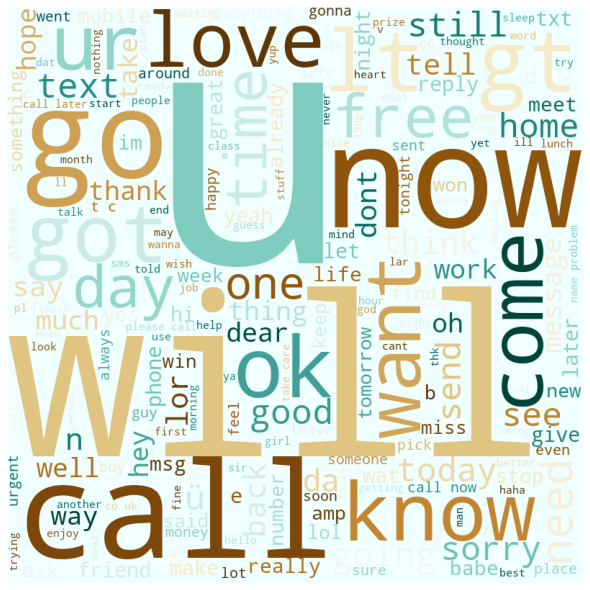

In [31]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**Same process for wordcloud, but use preprocessed data**

In [32]:
df = pd.DataFrame(messages_set, columns=['SMS', 'Label'])

only keep the SMS column

In [33]:
df.head()

,SMS,Label
0,"[bus, love]",ham
1,"[neva, worry, bout, truth, coz, truth, lead, h...",ham
2,"[www.applausestore.com, monthlysubscription, 5...",spam
3,"[want, get, lay, tonight, want, real, dog, loc...",spam
4,[see],ham


In [34]:
df2 = df[['SMS']]

In [35]:
df2

,SMS
0,"[bus, love]"
1,"[neva, worry, bout, truth, coz, truth, lead, h..."
2,"[www.applausestore.com, monthlysubscription, 5..."
3,"[want, get, lay, tonight, want, real, dog, loc..."
4,[see]
...,...
5567,"[derek, class]"
5568,"[time, come]"
5569,"[secret, admirer, look, make, contact, u-find,..."
5570,"[late, love, mum]"


In [36]:
for val in df2:
     
    val = str(val)
 
    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='azure', colormap='BrBG',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

**plot the WordCloud2 image**       

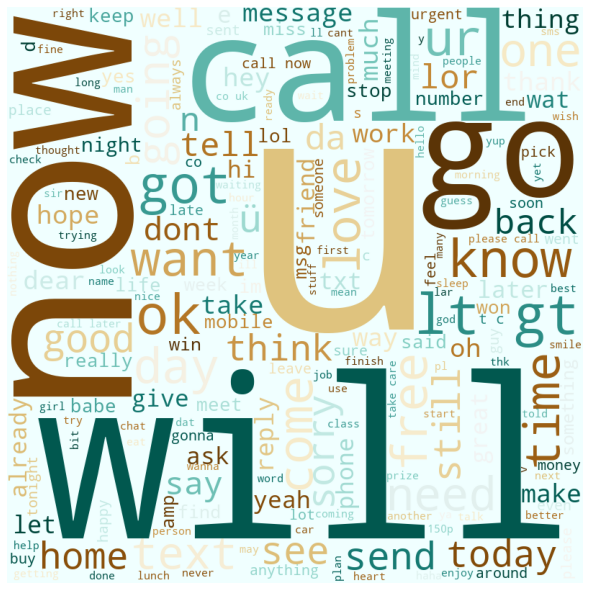

In [37]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**Play with other visualizations**

In [38]:
spam[‘SMS’].str.len().hist()

SyntaxError: invalid character '‘' (U+2018) (Temp/ipykernel_13708/2764817154.py, line 1)